# Linear Regression

## Goal - Predict the reviews

## Input
Data set - [Las Vegas Strip](https://archive.ics.uci.edu/ml/datasets/Las+Vegas+Strip) 

In [ ]:
# Import libraries

import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import metrics

In [ ]:
# Import data from local 

data_link = 'LasVegasTripAdvisorReviews-Dataset.csv'
df = pd.read_csv(data_link, sep = '\;', engine='python')

In [ ]:
df.describe()

,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel stars,Nr. rooms,Member years
count,504.000000,504.000000,504.000000,504.000000,504.0,504.0,504.0,504.0,504.0,504.0,504.000000,504.000000,504.000000
mean,48.130952,16.023810,31.751984,4.123016,1.0,1.0,1.0,1.0,1.0,1.0,4.142857,2196.380952,4.357143
std,74.996426,23.957953,48.520783,1.007302,0.0,0.0,0.0,0.0,0.0,0.0,0.774487,1285.476807,2.926439
min,1.000000,0.000000,0.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,3.000000,188.000000,0.000000
25%,12.000000,5.000000,8.000000,4.000000,1.0,1.0,1.0,1.0,1.0,1.0,3.500000,826.000000,2.000000
50%,23.500000,9.000000,16.000000,4.000000,1.0,1.0,1.0,1.0,1.0,1.0,4.000000,2700.000000,4.000000
75%,54.250000,18.000000,35.000000,5.000000,1.0,1.0,1.0,1.0,1.0,1.0,5.000000,3025.000000,6.000000
max,775.000000,263.000000,365.000000,5.000000,1.0,1.0,1.0,1.0,1.0,1.0,5.000000,4027.000000,13.000000


## Summary:

- We have a dataset of 504 rows by 20 cols
- Originally most of the datatypes were Python 'objects' and needed to be converted to the correct categorical or integer types
- Anomalies discovered in this dataset in both 'Hotel stars' and 'Member years' columns. They are either imputed or corrected through the methodologies most fitted.  
    
    o Hotel stars: had periods (.) instead of commas (,)
    
    o Member years: had a negative number for a counting up positive value






In [ ]:
# Check for any missing values

df.isna().any()

User country         False
Nr. reviews          False
Nr. hotel reviews    False
Helpful votes        False
Score                False
Period of stay       False
Traveler type        False
Pool                 False
Gym                  False
Tennis court         False
Spa                  False
Casino               False
Free internet        False
Hotel name           False
Hotel stars          False
Nr. rooms            False
User continent       False
Member years         False
Review month         False
Review weekday       False
dtype: bool

In [ ]:
# Check the dtypes

df.dtypes

User country         object
Nr. reviews           int64
Nr. hotel reviews     int64
Helpful votes         int64
Score                 int64
Period of stay       object
Traveler type        object
Pool                 object
Gym                  object
Tennis court         object
Spa                  object
Casino               object
Free internet        object
Hotel name           object
Hotel stars          object
Nr. rooms             int64
User continent       object
Member years          int64
Review month         object
Review weekday       object
dtype: object

In [ ]:
# Convert the dtypes to match with the data

# Change bool values to integers
list_to_booleans = ['Pool', 'Gym', 'Tennis court', 'Spa', 'Casino', 'Free internet']

# Dtype conversions
df[list_to_booleans] = df[list_to_booleans].astype(bool).astype('int64')

# Hotel Stars have values like 4,5 which is converted to 4.5 for further analysis
df['Hotel stars'] = df['Hotel stars'].str.replace(',', '.').astype('float64')

In [ ]:
def number_negative(df):
    """"
    Loops thru every numeric col to check for negative #'s
    There is definitely 1 detected in the Member Years col
    """

    # Find all numeric col's
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    num_df = df.select_dtypes(include = numerics)
    
    # Check if any of those numeric col's have a negative #
    negative_number_index = []
    print("col's detected =")
    
    for col in num_df:
        print(col)
        if (df[col].values < 0).any():
            negative_number_index = df[df[col] < 0].index.tolist()
            
    print('negative_number_index =', negative_number_index)
    
    # For any negative #'s found, convert them into the mode of the col
    for row in negative_number_index:
        df.at[row, col] = df[col].mode()
        
    return df

df = number_negative(df)

col's detected =
Nr. reviews
Nr. hotel reviews
Helpful votes
Score
Pool
Gym
Tennis court
Spa
Casino
Free internet
Hotel stars
Nr. rooms
Member years
negative_number_index = [75]


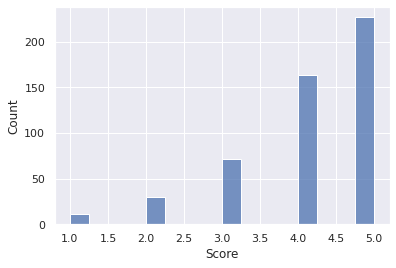

In [ ]:
# Plot histogram plot of score
# Set a dark background

sns.set(style = 'darkgrid')
sns.histplot(data = df['Score'])
plt.show()

## Feature Engineering

#### 2.1 - Split the data via train-test split

In [ ]:
def stratified_split(df, size, seed, stratum):
    """ 
    UDF named stratified_split to shuffle the data and return a set of train and a set of test data 
    AFTER splitting them by stratum
    """
    # Shuffle all of the data (frac = 1)
    df = df.sample(frac = 1, random_state = seed)

    # Split into a train and test set
    df_test = df.groupby(stratum).sample(frac = size, random_state = seed)
    test_indices = df_test.index
    df_train = df.drop(test_indices)
   
    # Separate other attributes from the predicting attribute on the train set
    x_train = df_train.drop('Score', axis=1)
    
    # Separate the predicting attribute into Y for model training on the train set
    y_train = df_train['Score']
    
    # Perform the same on the test set
    x_test = df_test.drop('Score', axis=1)
    y_test = df_test['Score']
    
    return x_train, x_test, y_train, y_test, df_train, df_test;

In [ ]:
# Stratify by the 'Hotel name'
# Pass in just 20% for test
x_train, x_test, y_train, y_test, df_train, df_test = stratified_split(df, .2, 7, 'Hotel name')

# Check if the split is done correctly or not
labels = df['Hotel name'].unique()

for lbl in labels:
    total_lbl_df = df[df['Hotel name'] == lbl]
    train_lbl_df = df_train[df_train['Hotel name'] == lbl]
    test_lbl_df = df_test[df_test['Hotel name'] == lbl]
    print(f'''{lbl} 
           -----------
           Total = {len(total_lbl_df)}
           Train = {len(train_lbl_df)}
           Test = {len(test_lbl_df)}
           ''')

Circus Circus Hotel & Casino Las Vegas 
           -----------
           Total = 24
           Train = 19
           Test = 5
           
Excalibur Hotel & Casino 
           -----------
           Total = 24
           Train = 19
           Test = 5
           
Monte Carlo Resort&Casino 
           -----------
           Total = 24
           Train = 19
           Test = 5
           
Treasure Island- TI Hotel & Casino 
           -----------
           Total = 24
           Train = 19
           Test = 5
           
Tropicana Las Vegas - A Double Tree by Hilton Hotel 
           -----------
           Total = 24
           Train = 19
           Test = 5
           
Caesars Palace 
           -----------
           Total = 24
           Train = 19
           Test = 5
           
The Cosmopolitan Las Vegas 
           -----------
           Total = 24
           Train = 19
           Test = 5
           
The Palazzo Resort Hotel Casino 
           -----------
           Total = 24
   

In [ ]:
class My_encoder:
    '''
    This class creates a pipline which is used for applying SimpleImputer, MinMaxScaler & OneHotEncoder.
    '''

    def __init__(self):
        pass
        
    def encoder_pipeline(self, numerical_features, categorical_features):
        
        # Apply these functions to ONLY the numeric features
        # Just in case, impute NULL values with mean

        numeric_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy = 'mean')),
        ('scale', MinMaxScaler())
        ])

        # Apply these functions to ONLY to the categorical features
        # Then, apply One Hot Encoder

        categorical_pipeline = Pipeline(steps = [
            ('impute', SimpleImputer(strategy = 'most_frequent')),
            ('one-hot', OneHotEncoder(handle_unknown = 'ignore', sparse = False)),
        ])
        
        # Runs the above numerical and categorical pipeline functions and create final processor

        full_processor = ColumnTransformer(transformers=[
        ('number', numeric_pipeline, numerical_features),
        ('category', categorical_pipeline, categorical_features)
        ])
        
        return full_processor

In [ ]:
# Polynomial features function by raising existing features to an exponent
def poly(x, y, degree_value, interaction_only_value):
  
    PF = PolynomialFeatures(degree=degree_value, interaction_only= interaction_only_value, include_bias=True)
    Train_X_polied = PF.fit_transform(x)
    Test_X_polied = PF.transform(y)
    
    return Train_X_polied, Test_X_polied

In [ ]:
# Defining the features
numerical_features = ['Nr. reviews','Nr. hotel reviews','Helpful votes','Hotel stars', 'Nr. rooms', 
                      'Member years', 'Hotel stars']
categorical_features = ['Period of stay', 'Traveler type', 'Review month', 'Review weekday', 'User country', 'User continent', 'Hotel name',
                       'Pool', 'Gym', 'Tennis court', 'Spa', 'Casino', 'Free internet']
target = 'Score'

# Call earlier pipeline 
enc = My_encoder()
full_processor = enc.encoder_pipeline(numerical_features, categorical_features)

# Transform data - OHE, min max scaler for both test and train
Train_x = full_processor.fit_transform(df_train)
Test_y = full_processor.transform(df_test)

# Polynomial feature for test and train dataset
Train_X_polied, Test_X_polied = poly(Train_x, Test_y, 2, False)

### Model Fitting, Evaluation and Selection

#### Linear Regression with MAE & MSE

In [ ]:
'''
    Huber ('huber'): This is a robust loss function that combines both least absolute and squares deviation;
    epsilon value should be >= than 1.0 by default it's 1.35
'''
lr = HuberRegressor(epsilon = 1.0, 
                    fit_intercept = False, 
                    max_iter = 500, 
                    alpha = 0.0001).fit(X = Train_X_polied, 
                                        y = df_train[target])

y_hat_training = lr.predict(Train_X_polied)

mae_train = mean_absolute_error(y_hat_training, df_train[target])
print(f'Linear Regression MAE Score on training data = {mae_train}') 

mse_train = (mean_squared_error(y_hat_training, df_train[target]))
print(f'Linear Regression MSE Score on training data = {mse_train}') 

Linear Regression MAE Score on training data = 0.0595548936946987
Linear Regression MSE Score on training data = 0.05860799696691065
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


#### Poisson Regression

In [ ]:
# Create Poisson regression object
pr = linear_model.PoissonRegressor()

# Fit the model
pr.fit(X = Train_X_polied, y = df_train[target])

# Train prediction!
y_hat_training_pr = pr.predict(Train_X_polied)

#### Mapping prediction result to target format

In [ ]:
def inline_pred_tar(y_hat_testing):
    """
    Function to map model prediction to the target format, which in this case is int
    """
    # Convert the dtype to integer as our final score is an interger value
    y_hat_testing_inline = y_hat_testing.astype('int')
    y_hat_testing_inline_res = []

    # This loop will handle the outlier outputs
    for i in y_hat_testing_inline:
        if i > 5:
            y_hat_testing_inline_res.append(5)
        elif i < 1:
            y_hat_testing_inline_res.append(1)
        else:
            y_hat_testing_inline_res.append(i)
            
    # Converting the result to np array
    y_hat_testing_inline_res_op = np.array(y_hat_testing_inline_res) 
    return y_hat_testing_inline_res_op

#### Linear regression predictions

In [ ]:
# Predicted Score on testing data
y_hat_testing_lr = lr.predict(Test_X_polied)

# Actual Score
y_true_testing_lr = df_test[target]

#### Poisson regression predictions

In [ ]:
# Predicted Score on testing data
y_hat_testing_pr = pr.predict(Test_X_polied)

# Actual Score
y_true_testing_pr = df_test[target]

#### Evaluate the model based using MSE on testing data

In [ ]:
def mean_squared_error_fun(y_hat, y_true):
    return mean_squared_error(y_hat, y_true)

y_hat_testing_inline_lr = inline_pred_tar(y_hat_testing_lr)
y_hat_testing_inline_pr = inline_pred_tar(y_hat_testing_pr)

lr_mse_test = mean_squared_error_fun(y_hat_testing_inline_lr, df_test[target])
pr_mse_test = mean_squared_error_fun(y_hat_testing_inline_pr, df_test[target])

print(f'MSE for linear regression model on testing data = {lr_mse_test}')
print(f'MSE for poisson regression model on testing data = {pr_mse_test}')

MSE for linear regression model on testing data = 2.238095238095238
MSE for poisson regression model on testing data = 1.5142857142857142


### Prediction and Prediction Summary

#### Predictions

In [ ]:
'''
    Predictions on test data is done in Part |||, to get the evaluation using MSE on testing data. Same results are been
    used for part IV.
'''

'\n    Predictions on test data is done in Part |||, to get the evaluation using MSE on testing data. Same results are been\n    used for part IV.\n'

### Box Plot

In [ ]:
# Convert the predicted values to DF
df_lr = pd.DataFrame({'Actual':y_true_testing_lr, 'Predicted':y_hat_testing_inline_lr})
df_lr['model'] = df_lr.model = 'lr'

df_pr = pd.DataFrame({'Actual':y_true_testing_pr, 'Predicted':y_hat_testing_inline_pr})
df_pr['model'] = df_pr.model = 'pr'

# Concat the DFs to compare the result
prediction = pd.concat([df_lr, df_pr])

<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

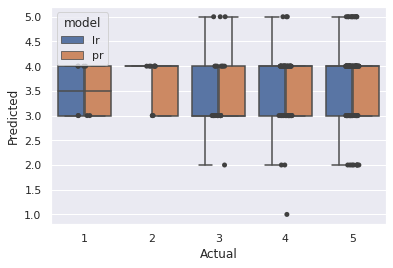

In [ ]:
# Create overlapping boxplot with stripplots
sns.boxplot(x = 'Actual', 
            y = 'Predicted', 
            data = prediction, 
            showfliers = False, 
            hue = 'model')

# To look at the data
sns.stripplot(x = 'Actual', 
              y = 'Predicted', 
              data = prediction, 
              color = ".25")